In [1]:
# Load necessary libraries
import pandas as pd 
import numpy as np  
import matplotlib.pyplot as plt 
from scipy import stats
import seaborn as sns
from matplotlib import gridspec
import math

sns.set()# Setting seaborn as default style
sns.set_theme(style="darkgrid")

# Data Cleaning and Organization

In [21]:
# Card info
cards_csv = pd.read_csv('../dataset/cards.csv', sep=";")
prices_csv = pd.read_csv('../dataset/cardPrices.csv', sep=",")

# perform inner join based on UUID, then drop null values
all_data = pd.merge(prices_csv, cards_csv, on="uuid")
all_data.dropna(inplace=True)
data = all_data.reset_index(drop=True)


data_usd = data[data['currency'] == 'USD']


In [16]:
def interpret_p_value(p_value, alpha=0.05):
    if p_value < alpha:
        return "Reject the null hypothesis. There is a statistically significant difference."
    else:
        return "Fail to reject the null hypothesis. There is no statistically significant difference."


# Artists affect prices?

Assuming USD only for analysis

- Null hypothesis $H_0$: artists have no impact on prices
- Alt hypothesis $H_A$: artists do have an impact

## Intepretation

In your case, an F-statistic of 7.2039 suggests that there is a significant amount of variance between the average prices of cards from different artists compared to the variance within each artist's prices.

Since the P-value is significantly less than 0.05, you can reject the null hypothesis (H0), which states that artists have no impact on prices.


### Implications
**Artist Impact:** The results suggest that the artist associated with a card does influence its price, meaning that some artists may produce cards that are valued more highly in the market than others.

**Market Insights:** For collectors and sellers, understanding these differences can inform buying and pricing strategies.

In [13]:
# Hypothesis H0: Artists have no impact on prices

# groups mean prices by artists
artists = data_usd['artist'].unique()

# Create a group of prices for each unique artist to performing a ANOVA test
artist_price_groups = [ data_usd[data_usd['artist'] == artist]['price'].to_numpy()
    for artist in artists if len(data_usd[data_usd['artist'] == artist]['price']) > 1 ]

# Removing Zero Variance artist prices
filtered_prices = [row for row in artist_price_groups if np.var(row) > 0]

In [18]:
# Conduct the one-way ANOVA
# Paper cards, no outliers, Q1_Q3, only in USD
t_stat, p_value = stats.f_oneway(*filtered_prices)

print("Can artist impact prices: \n Data: Paper cards, no outliers, Q1_Q3, only in USD")
print("T-statistic ANOVA: %.4f" % t_stat)
print("P-value: %.6f" % p_value);
print(interpret_p_value(p_value))

Can artist impact prices: 
 Data: Paper cards, no outliers, Q1_Q3, only in USD
T-statistic ANOVA: 7.2039
P-value: 0.000000
Reject the null hypothesis. There is a statistically significant difference.


---

# Prediction Exercises

Trying to understand what affects the price the most

In [55]:
def removeOutliers(data, col):
    Q3 = np.quantile(data[col], 0.75)
    Q1 = np.quantile(data[col], 0.25)
    IQR = Q3 - Q1
 
    lower_range = Q1 - 1.5 * IQR
    upper_range = Q3 + 1.5 * IQR
    outlier_free_list = [x for x in data[col] if ((x > lower_range) & (x < upper_range))]
    filtered_data = data.loc[data[col].isin(outlier_free_list)]
    return filtered_data

In [54]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()

# User paper Game Availability given the price variance difference between mtgo and paper
paper = removeOutliers(data_usd[data_usd["gameAvailability"]=='paper'], 'price')


# Can we predict price by rarity?

After removing price outliers and creating a linear regression using the rarity variable, we arrive at the results:

- Mean Squared Error: 3.419326457001876
- R-squared: 0.09364985309111518

R-squared value of 0.0936 means that only about 9.36% of the variance in card prices can be explained by rarity alone. We can say that Rarity is not a strong predictor of price in your dataset, and other factors may have more influence card pricing.

In [62]:
# Price Prediction based on Rank
# One-hot encode rarity

# Fit and transform the rarity column
paper.loc[:, 'rarity_encoded'] = label_encoder.fit_transform(paper['rarity'])

#variables of analysis
# Define features (X) and target variable(y)
X = paper[['rarity_encoded']]
y = paper['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



Mean Squared Error: 3.419326457001876
R-squared: 0.09364985309111518


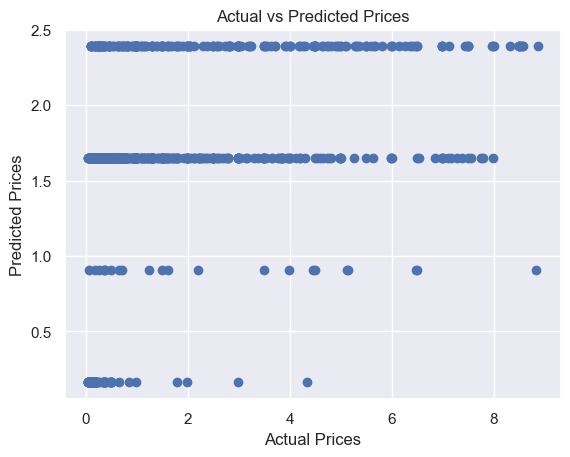

In [63]:
# Create linear regression model
model = LinearRegression()
model.fit(X_train, y_train)


y_pred = model.predict(X_test)

# Calculate metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r2}')

plt.scatter(y_test, y_pred)
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.title('Actual vs Predicted Prices')
#plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red')  # Diagonal line for reference
plt.show()

# EDH Recomendations can predict price?

- Mean Squared Error: 3.570392893532709
- R-squared: 0.053607146240955195

R-squared value of 0.0536 means that only about 5.36% of the variance in card prices can be explained by rarity alone. We can say that EDH Recomendations is not a strong predictor of price in your dataset, and other factors may have more influence card pricing.

In [64]:

# variables of analysis
# Define features (X) and target variable(y)
X = paper[['edhrecRank']]
y = paper['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Mean Squared Error: 3.570392893532709
R-squared: 0.053607146240955195


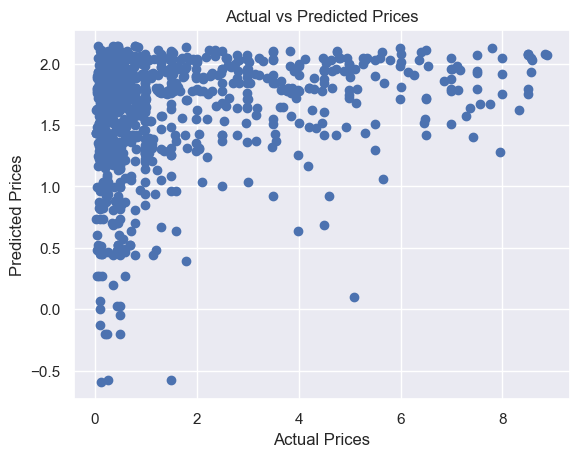

In [65]:
# Create linear regression model
model = LinearRegression()
model.fit(X_train, y_train)


y_pred = model.predict(X_test)

# Calculate metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r2}')

plt.scatter(y_test, y_pred)
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.title('Actual vs Predicted Prices')
#plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red')  # Diagonal line for reference
plt.show()